# Нужно провести анализ, где главными задачами являются:
# 1. Влияние разреженности данных на модель
# 2. Подбор оптимальной модели

In [1]:
import numpy as np
import pandas as pd 

data = pd.read_csv('weatherAUS.csv')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data.tail(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,0.0,No
142192,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,0.0,No


In [30]:
target = data['RainTomorrow']
data = data.drop(columns=['RainTomorrow'], axis=1)

In [4]:
for col in data.columns:
    print(col, data[col].isna().sum(), data[col].dtype, data[col].unique().shape[0])

Date 0 object 3436
Location 0 object 49
MinTemp 637 float64 390
MaxTemp 322 float64 506
Rainfall 1406 float64 680
Evaporation 60843 float64 357
Sunshine 67816 float64 146
WindGustDir 9330 object 17
WindGustSpeed 9270 float64 68
WindDir9am 10013 object 17
WindDir3pm 3778 object 17
WindSpeed9am 1348 float64 44
WindSpeed3pm 2630 float64 45
Humidity9am 1774 float64 102
Humidity3pm 3610 float64 102
Pressure9am 14014 float64 547
Pressure3pm 13981 float64 550
Cloud9am 53657 float64 11
Cloud3pm 57094 float64 11
Temp9am 904 float64 441
Temp3pm 2726 float64 501
RainToday 1406 object 3
RISK_MM 0 float64 681
RainTomorrow 0 object 2


# Instead of removing nans let's predict them!

## Evaporation (60843 nans)
## Sunshine (67816 nans)
## Pressure9am (14014 nans)
## Pressure3pm (13981 nans)
## Cloud9am (53657 nans)
## Cloud3pm (57094 nans)
## Total (142191 rows)

In [5]:
predict_cols = ['Evaporation', 'Sunshine', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']

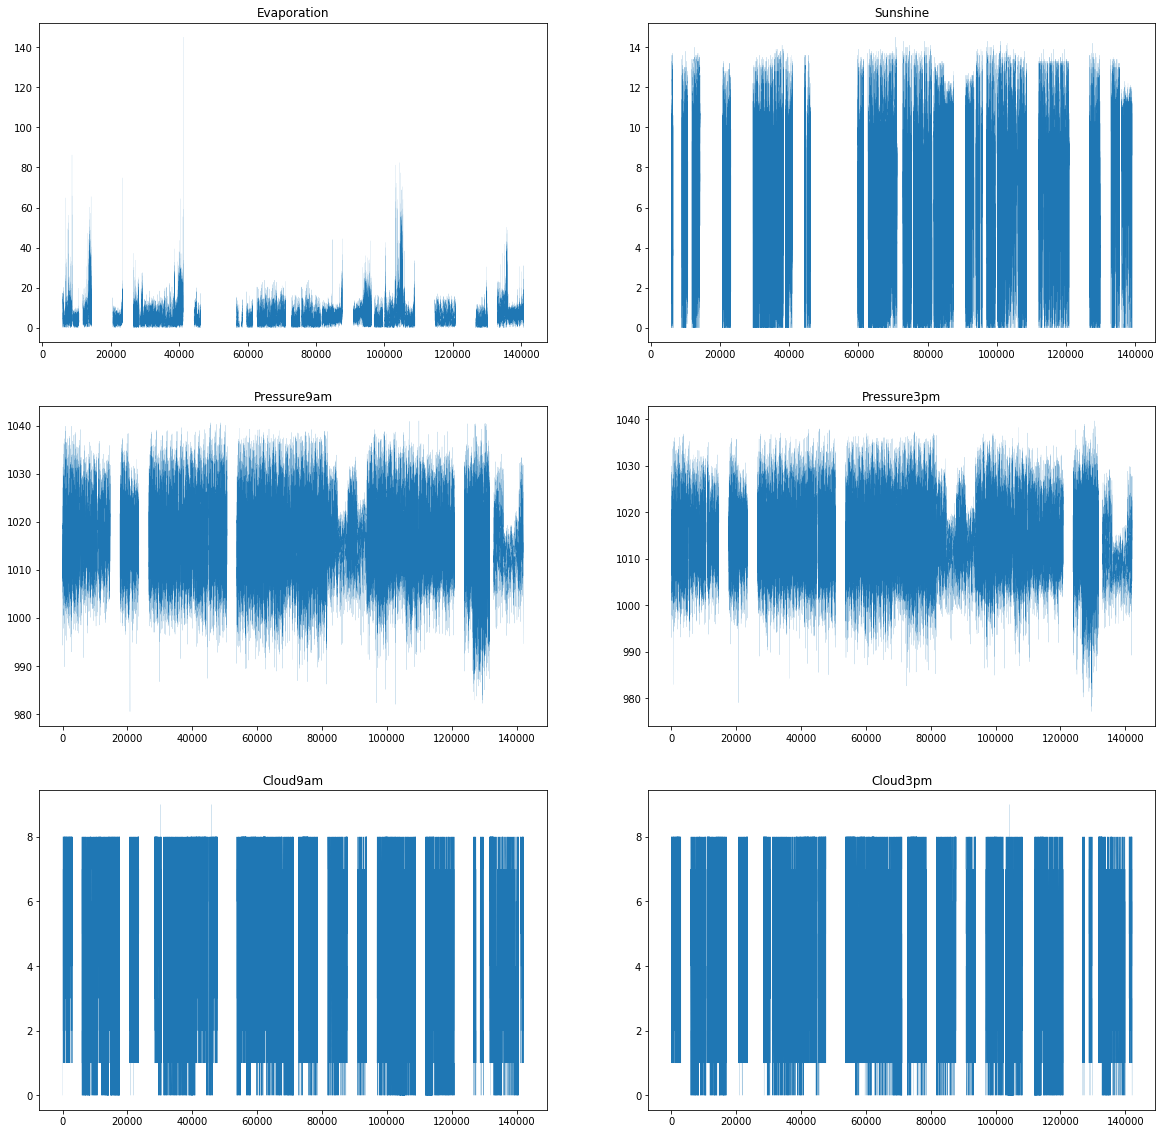

In [6]:
# Plot dependecy predictable columns on index
fig, axes = plt.subplots(3,2, figsize=(20,20))
for i, (ax, col) in enumerate(zip(axes.ravel(), predict_cols)):
    ax.plot(data[col], linewidth=0.1)
    ax.set_title(col)
plt.show()

In [8]:
def dummy_dates(d):
    # idk why but let it place here:)
    if d is not data:
        print('d is not data')
        return None
    
    # dummy years
    for year in range(2008, 2018):
        year = str(year)
        ix = 'Year-'+year
        d[ix] = d['Date'].str.contains(year+'-[0-9][0-9]-[0-9][0-9]').astype(np.int8)
    
    # dummy months
    for month in range(1, 13):
        if month < 10:
            month = '0'+str(month)
        else:
            month = str(month)
        ix = 'Month-'+month
        d[ix] = d['Date'].str.contains('[0-9][0-9][0-9][0-9]-'+month+'-[0-9][0-9]').astype(np.int8)
        
    # dummy days
    for day in range(1, 32):
        if day < 10:
            day = '0'+str(day)
        else:
            day = str(day)
        ix = 'Day-'+day
        d[ix] = d['Date'].str.contains('[0-9][0-9][0-9][0-9]-[0-9][0-9]-'+day).astype(np.int8)
        
    d = d.drop(columns=['Date'], axis=1)
    return d
    

In [9]:
def make_predict(X, y):
    # predicting parameter is numeric
    # preprocessing data
    # determining cat and num columns
    num_columns = [col for col in X.columns if X[col].dtype != 'object']
    cat_columns = [col for col in X.columns if X[col].dtype == 'object'] 
    
    # dummy categorical
    for col in cat_columns:
        temp = pd.get_dummies(X[col], prefix=col, prefix_sep='-', dtype=np.uint8)
        X = pd.concat([X, temp], axis=1)
    X = X.drop(columns=cat_columns, axis=1)
    # dates already dummied so it is not possible to use time-series prediction
    # scaling numeric
    from sklearn.preprocessing import RobustScaler

    for col in num_columns:
        temp = np.array(X[col].values)
        temp = RobustScaler().fit_transform(temp.reshape(-1,1))
        X[col] = pd.Series(data=temp.ravel(), name=col)
        
    # X = pd.DataFrame(RobustScaler().fit_transform(X))
    
    # splitting in fit and target parts
    target_indexes = y[y.isna() == True].index
    train_indexes = y[y.isna() == False].index
    y_train = y.iloc[train_indexes]
    X_train = X.iloc[train_indexes]
    X_target = X.iloc[target_indexes]
        
    # use ordinary linear model
    #from sklearn.linear_model import LinearRegression
    #model = LinearRegression()
    from sklearn.neighbors import KNeighborsRegressor
    model = KNeighborsRegressor()
    # fitting model
    
    print('...fitting', end=' ')
    model.fit(X_train, y_train)
    # making predict
    print('fitted!', end=' ')
    y_target = model.predict(X_target)
    print('...and predicted!')
    return y_target



In [25]:
def predict_nans(data, times=10):
    # dummy dates
    data = dummy_dates(data)
    analyse=[]
    for process in range(times):
        print('Processing {0}: '.format(process))
        for col in predict_cols:
            print(col, end=' ')
            
            # preprocssing data
            target_data = data[col].copy(deep=True)
            learning_data = data.drop(columns=[col], axis=1)
            
            # filling nans in non-target columns
            # just for the first iteration
            for c in learning_data:
                if process == 0:
                    if learning_data[c].dtype == 'object':
                        filler = learning_data[c].describe()['top']
                    else:
                        filler = learning_data[c].describe()['mean']
                    learning_data[c] = learning_data[c].fillna(filler)
                
            # predicting parameter
            target_data[target_data.isna() == True] = make_predict(learning_data, target_data)
            data[col] = target_data
            analyse.append(target_data)
    return analyse

In [12]:
analyse = predict_nans(data, times=1)

Processing 0: Evaporation ...fitting fitted!
Sunshine ...fitting fitted!
Pressure9am ...fitting fitted!
Pressure3pm ...fitting fitted!
Cloud9am ...fitting fitted!
Cloud3pm ...fitting fitted!


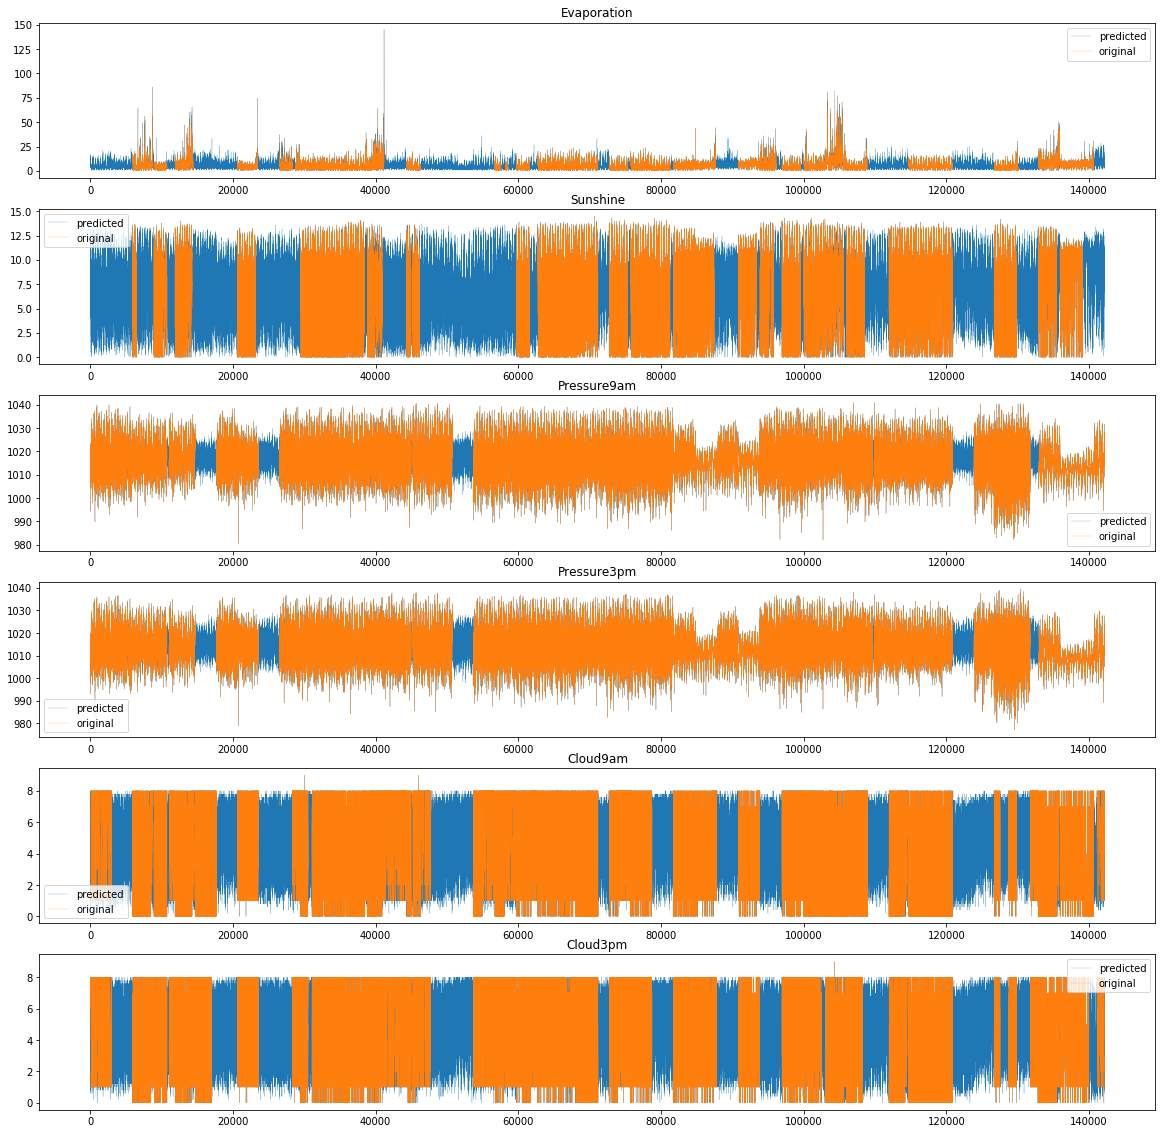

In [28]:
# Plot dependecy predictable columns on index
fig, axes = plt.subplots(6,1, figsize=(20,20))
for i, (ax, col, a) in enumerate(zip(axes.ravel(), predict_cols, analyse)):
    ax.plot(analyse[i], linewidth=0.2, label='predicted')
    ax.plot(data[col], linewidth=0.2, label='original')
    ax.legend()
    ax.set_title(col)
plt.show()

 Well, full-of-nans values forecasted well accurately except Pressure data: variance of forecasted values is kind of different from orginal data. By some reason it is not possible to make forecast more than one time because of model's error's raise (fitting data has no right format to use) but at the same time forecasted data looks very natural. In future:
    1. I have to fix that, add function to count difference between values forecasted in different iterations to make a better analyse.
    2. I want to make forecasts with time-series methods to see if there any difference between these or classic machine learning

 Now I want to see if there any benefit to forecast NaNs instead of erasing them or filling with top or mean values. I already had built a model with accuracy 85%. And yes, target data is not balanced. Despite this for current moment accuracy of model is precision metric.
 I use past model with it parameteres to compare past and present method as fairly as possible.



In [37]:
def past_fit(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier as rfc
    model = rfc(n_estimators=150)
    model.fit(X_train, y_train)

    print('Train ', model.score(X_train, y_train))
    print('Test ', model.score(X_test, y_test))

cat = [c for c in data.columns[1:] if data[c].dtype == 'object']
num = [c for c in data.columns if data[c].dtype != 'object']

try:
    temp = pd.get_dummies(data=data[cat], prefix=cat, prefix_sep='-', dtype=np.uint8)
    data = pd.concat([data, temp], axis=1)
    data = data.drop(columns=cat, axis=1)
except:
    pass

for col in data.columns[1:]:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].describe()['top'])
    else:
        data[col] = data[col].fillna(data[col].describe()['mean'])
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Date'], axis=1), target, random_state=8)

past_fit(X_train, X_test, y_train, y_test)

Train  1.0
Test  0.9999718698134968
